In [1]:
import matplotlib
import matplotlib.pyplot as plt
from typing import Tuple
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    auc,
    average_precision_score,
    log_loss,
    precision_recall_curve,
)
from sklearn.metrics import (
    roc_curve, roc_auc_score 
)
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler

In [2]:
data_path = Path("../data")

In [3]:
df = pd.read_parquet(data_path / "full_data.parquet")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56335 entries, 0 to 56334
Data columns (total 69 columns):
 #   Column                                          Non-Null Count  Dtype    
---  ------                                          --------------  -----    
 0   advertiser_zrive_id                             56335 non-null  int64    
 1   period_int                                      56335 non-null  int64    
 2   monthly_published_ads                           56335 non-null  int64    
 3   monthly_unique_published_ads                    56335 non-null  int64    
 4   monthly_contracted_ads                          56335 non-null  int64    
 5   monthly_leads                                   56335 non-null  int64    
 6   monthly_visits                                  56335 non-null  float64  
 7   monthly_oro_ads                                 56335 non-null  int64    
 8   monthly_plata_ads                               56335 non-null  int64    
 9   monthly_destacados_ads

In [5]:
df["churn"].value_counts(normalize=True)

churn
0.0    0.922925
1.0    0.077075
Name: proportion, dtype: float64

- Unbalanced problem

#### Drop duplicate month feature

In [6]:
df = df.drop(columns=["period_int"])

In [7]:
df.columns[df.isnull().any()]

Index(['monthly_avg_ad_price', 'monthly_distinct_ads', 'tenure',
       'months_since_last_contract', 'monthly_avg_ad_price_3_months_mean',
       'monthly_avg_ad_price_3_months_mean_delta'],
      dtype='object')

#### Ternure

- Set tenure to 0 for users who have no activity or contract. This ensures that users with no recorded activity or contract are considered as having 0 months of tenure.

In [8]:
df['tenure'] = df['tenure'].fillna(0)

#### months_since_last_contract

- If `months_since_last_contract` is `NaN`, it indicates either no previous contract or they are in their first contract.
- We fill `NaN` with 0 to represent users with no prior contract or those on their first contract.

In [9]:
df['months_since_last_contract'] = df['months_since_last_contract'].fillna(0)

#### monthly_distinct_ads

- When there is at least one non-null month, I will impute the missing values with the first non-null value and propagate it backwards. If there are any nulls later on, we will propagate the non-null value forward as well. For users with all null values, I will impute it with the value of monthly_published_ads, since monthly_distinct_ads represents a similar metric.

In [10]:
df['monthly_distinct_ads'] = df.groupby('advertiser_zrive_id')['monthly_distinct_ads'].transform(
    lambda x: x.bfill().ffill()
)

df['monthly_distinct_ads'] = df['monthly_distinct_ads'].fillna(df['monthly_published_ads'])


#### monthly_avg_ad_price

- I will impute the missing values in the first months with the first non-null value, carrying it backwards. If all months are null, I will impute with the global mean of the entire dataset.

In [11]:
global_mean_price = df['monthly_avg_ad_price'].mean()

df['monthly_avg_ad_price'] = (
    df
    .groupby('advertiser_zrive_id')['monthly_avg_ad_price']
    .transform(lambda group: group.bfill().ffill())
)

df['monthly_avg_ad_price'] = df['monthly_avg_ad_price'].fillna(global_mean_price)


#### monthly_avg_ad_price_3_months_mean and monthly_avg_ad_price_3_months_delta

- We had to recompute the variables monthly_avg_ad_price_3_months_mean and monthly_avg_ad_price_3_months_delta after imputing the null values in 'monthly_avg_ad_price'.

In [12]:
from typing import List

def create_agg_stats(
        df: pd.DataFrame, 
        features: List[str], 
        months = 3, 
        agg_funcs=['mean', 'std', 'min', 'max'], 
        add_deltas=True
) -> pd.DataFrame:
    '''
    Adds aggregate features over the last months for the features passed to the function 
    '''

    df_agg = df.copy().sort_values(by=['advertiser_zrive_id','month_period'], ascending=[True, True])

    for feature in features:
        for agg_func in agg_funcs:
            col_name = f'{feature}_{months}_months_{agg_func}'
            df_agg[col_name] = (
                df_agg.groupby('advertiser_zrive_id')[feature]
                .transform(lambda x: x.rolling(window=months, min_periods=1).agg(agg_func))
            )

            if add_deltas and agg_func == 'mean':
                delta_col = f'{feature}_{months}_months_mean_delta'
                df_agg[delta_col] = df_agg[feature] - df_agg[col_name]

    df_agg = df_agg.sort_values(by=['advertiser_zrive_id','month_period'])

    return df_agg

df_final = df.drop(['monthly_avg_ad_price_3_months_mean', 'monthly_avg_ad_price_3_months_mean_delta'], axis=1)

created_columns = [
    'advertiser_zrive_id',
    'monthly_published_ads',
    'monthly_published_ads_3_months_mean',
    'monthly_published_ads_3_months_mean_delta',
    'monthly_unique_published_ads',
    'monthly_contracted_ads',
    'monthly_contracted_ads_3_months_mean',
    'monthly_contracted_ads_3_months_mean_delta',
    'monthly_leads',
    'monthly_leads_3_months_mean',
    'monthly_leads_3_months_mean_delta',
    'monthly_visits',
    'monthly_visits_3_months_mean',
    'monthly_visits_3_months_mean_delta',
    'monthly_oro_ads',
    'monthly_plata_ads',
    'monthly_destacados_ads',
    'monthly_pepitas_ads',
    'monthly_shows',
    'monthly_total_phone_views',
    'monthly_total_calls',
    'monthly_total_emails',
    'monthly_total_invoice',
    'monthly_total_invoice_3_months_mean',
    'monthly_total_invoice_3_months_mean_delta',
    'monthly_unique_calls',
    'monthly_unique_emails',
    'monthly_unique_leads',
    'monthly_avg_ad_price',
    'monthly_distinct_ads',
    'month_period',
    'tenure',
    'months_since_last_contract',
    'has_renewed',
    'monthly_total_premium_ads',
    'ratio_published_contracted',
    'ratio_published_contracted_3_months_mean',
    'ratio_published_contracted_3_months_mean_delta',
    'ratio_unique_published',
    'ratio_unique_published_3_months_mean',
    'ratio_unique_published_3_months_mean_delta',
    'ratio_premium_ads',
    'ratio_premium_ads_3_months_mean',
    'ratio_premium_ads_3_months_mean_delta',
    'leads_per_published_ad',
    'leads_per_published_ad_3_months_mean',
    'leads_per_published_ad_3_months_mean_delta',
    'leads_per_premium_ad',
    'leads_per_premium_ad_3_months_mean',
    'leads_per_premium_ad_3_months_mean_delta',
    'visits_per_published_ad',
    'visits_per_published_ad_3_months_mean',
    'visits_per_published_ad_3_months_mean_delta',
    'leads_per_visit',
    'leads_per_visit_3_months_mean',
    'leads_per_visit_3_months_mean_delta',
    'leads_per_shows',
    'leads_per_shows_3_months_mean',
    'leads_per_shows_3_months_mean_delta',
    'invoice_per_published_ad',
    'invoice_per_published_ad_3_months_mean',
    'invoice_per_published_ad_3_months_mean_delta',
    'invoice_per_lead',
    'invoice_per_lead_3_months_mean',
    'invoice_per_lead_3_months_mean_delta',
    'churn'
]

df_ratios = df[created_columns].copy()

features_to_aggregate = [
    'monthly_avg_ad_price',
]
agg_funcs = ['mean']

df = create_agg_stats(df_ratios, features = features_to_aggregate, months = 3, agg_funcs=agg_funcs, add_deltas=True)

In [13]:
df.columns[df.isnull().any()]

Index([], dtype='object')

In [14]:
info_cols = ["advertiser_zrive_id", "month_period", "user_id", "created_at", "order_date"]
label_col = ["churn"]

features_cols = [col for col in df.columns if col not in info_cols + label_col]

categorical_cols = []
binary_cols = ["has_renewed"]

numerical_cols = [col for col in features_cols if col not in categorical_cols + binary_cols]

In [15]:
train_cols = numerical_cols + binary_cols

### Data splits
#### In this section we will be spliting the data in 3 groups:
    - Training: to fit our models
    - Validation: to pick best model and hyperparametrisation. In addition, to perform calibration.
    - Test: to evaluate the final model performance.

In [16]:
train_start = "202303"
train_val_cutoff = "202312"
val_cutoff = "202401"

In [17]:
train_df = df[
    (df['month_period'] >= train_start) &
    (df['month_period'] <= train_val_cutoff)
]
val_df = df[
    (df['month_period'] > train_val_cutoff)
    & (df['month_period'] <= val_cutoff)
]

In [18]:
print("Churn distribution in train:")
print(train_df['churn'].value_counts(normalize=True))
print("\nChurn distribution in validation:")
print(val_df['churn'].value_counts(normalize=True))

Churn distribution in train:
churn
0.0    0.922396
1.0    0.077604
Name: proportion, dtype: float64

Churn distribution in validation:
churn
0.0    0.914557
1.0    0.085443
Name: proportion, dtype: float64


In [19]:
def plot_metrics( 
    model_name: str, 
    y_pred: pd.Series, 
    y_test: pd.Series,
    target_precision: float = 0.05,
    figure: Tuple [matplotlib.figure. Figure, np.array] = None,
):
    precision_, recall_, _ = precision_recall_curve(y_test, y_pred) 
    pr_auc = auc(recall_, precision_)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score (y_test, y_pred)
    if figure is None:
        fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    else:
        fig, ax = figure

    ax[0].plot(recall_, precision_, label=f"{model_name}; AUC: {pr_auc:.2f}")
    ax[0].set_xlabel("recall")
    ax[0].set_ylabel("precision")
    ax[0].set_title(f"Precision-recall Curve")
    ax[0].legend()
    ax[1].plot(fpr, tpr, label=f"AUC: {roc_auc:.2f}")
    ax[1].set_xlabel("FPR")
    ax[1].set_ylabel("TPR")
    ax[1].set_title("ROC Curve")
    ax[1].legend()

In [20]:
price_drop_threshold = -0.1 

y_pred_baseline1 = (
    (val_df['monthly_leads_3_months_mean_delta'] < -0.1) |  
    (val_df['monthly_visits_3_months_mean_delta'] < -0.1) |
    (val_df['ratio_published_contracted_3_months_mean_delta'] < -0.1) |
    (val_df['ratio_premium_ads_3_months_mean_delta'] < -0.1) |
    (val_df['leads_per_published_ad_3_months_mean_delta'] < -0.1) |
    (val_df['monthly_avg_ad_price_3_months_mean_delta'] < price_drop_threshold) |
    (val_df["has_renewed"] == 1)
).astype(int)

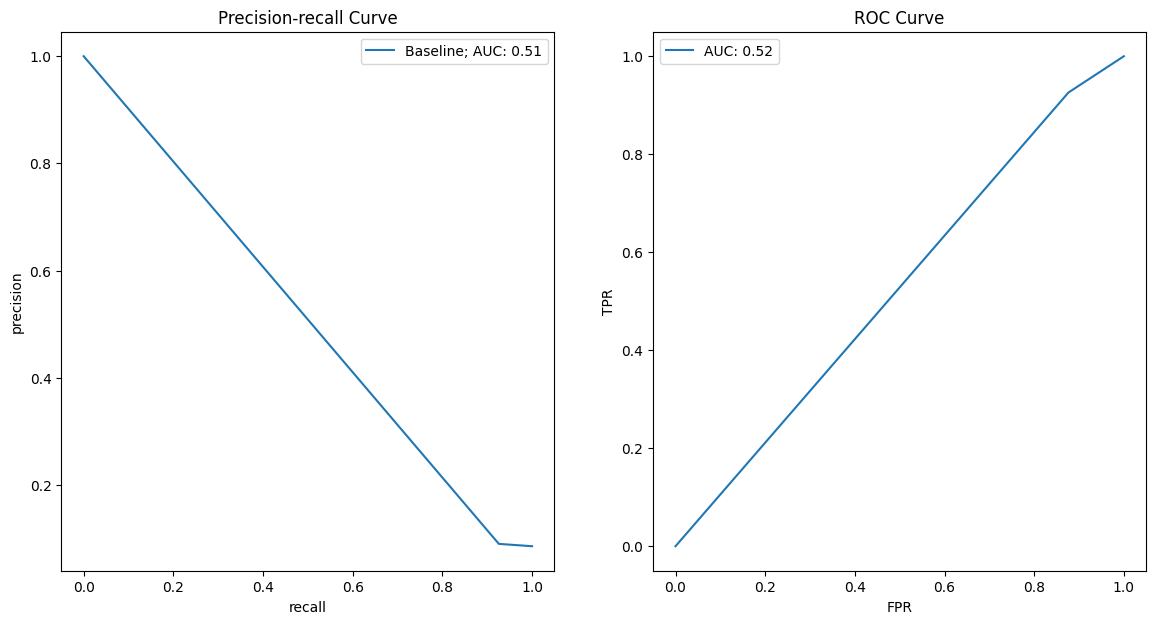

In [21]:
plot_metrics(
    model_name="Baseline",
    y_pred=y_pred_baseline1,
    y_test=val_df[label_col]
)

- The initial baseline, built using simple rules over several features, achieves an AUC-PR (Area Under the Precision-Recall Curve) of 0.51. Before moving forward, it's crucial to assess whether developing and maintaining a more complex model is truly worthwhile, given the production costs and resource consumption it would imply. Any new model must significantly outperform this baseline to justify its deployment.

- In this context, average precision becomes a key metric: our main objective is to maximize the detection of churned customers. Missing positive cases (churns) could have a high business impact, so the model's ability to prioritize and accurately identify as many churns as possible is far more important than purely optimizing for global accuracy or other metrics.

In [22]:
def feature_label_split(df: pd.DataFrame, label_col: str )-> Tuple [pd.DataFrame, pd.Series]:
    return df.drop(label_col, axis=1), df[label_col]

X_train, y_train = feature_label_split(train_df, label_col)
X_val, y_val = feature_label_split(val_df, label_col)

In [23]:
def evaluate_configuration(
    clf,
    X_train,
    y_train,
    X_val,
    y_val,
    train_aucs_list,
    val_aucs_list,
    train_ce_list,
    val_ce_list,
    train_aps_list,
    val_aps_list,
):
    val_preds = clf.predict_proba(X_val)[:, 1]
    train_preds = clf.predict_proba(X_train)[:, 1]
    
    train_auc = roc_auc_score(y_train, train_preds)
    val_auc = roc_auc_score(y_val, val_preds)

    train_crossentropy = log_loss(y_train, train_preds)
    val_crossentropy = log_loss(y_val, val_preds)

    train_ap = average_precision_score(y_train, train_preds)
    val_ap = average_precision_score(y_val, val_preds)

    train_aucs_list.append(train_auc)
    val_aucs_list.append(val_auc)
    train_ce_list.append(train_crossentropy)
    val_ce_list.append(val_crossentropy)
    train_aps_list.append(train_ap)
    val_aps_list.append(val_ap)

## Linear models

### Lasso regression

In [24]:
y_train = np.ravel(y_train)
y_val = np.ravel(y_val)

lr_push_train_aucs = []
lr_push_val_aucs = []
lr_push_train_ce = []
lr_push_val_ce = []
lr_push_train_aps = []
lr_push_val_aps = []

cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4, None]
for c in cs:
    lr1 = make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty="l1", C=c if c else 1.0, solver="saga") 
    )
    lr1.fit(X_train[train_cols], y_train)
    evaluate_configuration(
        lr1,
        X_train[train_cols],
        y_train,
        X_val[train_cols],
        y_val,
        lr_push_train_aucs,
        lr_push_val_aucs,
        lr_push_train_ce,
        lr_push_val_ce,
        lr_push_train_aps,
        lr_push_val_aps,
    )

    print(
        f"C: {c} done with train aucs {lr_push_train_aucs[-1]:.4f} and val aucs {lr_push_val_aucs[-1]:.4f}. "
        f"AP train: {lr_push_train_aps[-1]:.4f} and val: {lr_push_val_aps[-1]:.4f}. "
        f"Cross entropy train: {lr_push_train_ce[-1]:.4f}, val: {lr_push_val_ce[-1]:.4f}."
    )

C: 1e-08 done with train aucs 0.5000 and val aucs 0.5000. AP train: 0.0776 and val: 0.0854. Cross entropy train: 0.4278, val: 0.4342.
C: 1e-06 done with train aucs 0.5000 and val aucs 0.5000. AP train: 0.0776 and val: 0.0854. Cross entropy train: 0.4267, val: 0.4332.
C: 0.0001 done with train aucs 0.5000 and val aucs 0.5000. AP train: 0.0776 and val: 0.0854. Cross entropy train: 0.4276, val: 0.4341.


c:\Users\eduez\AppData\Local\pypoetry\Cache\virtualenvs\zrive-ds-s1huuNnt-py3.11\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


C: 0.01 done with train aucs 0.7142 and val aucs 0.6502. AP train: 0.1546 and val: 0.1344. Cross entropy train: 0.2543, val: 0.2840.


c:\Users\eduez\AppData\Local\pypoetry\Cache\virtualenvs\zrive-ds-s1huuNnt-py3.11\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


C: 1 done with train aucs 0.7205 and val aucs 0.6581. AP train: 0.1613 and val: 0.1352. Cross entropy train: 0.2521, val: 0.2850.


c:\Users\eduez\AppData\Local\pypoetry\Cache\virtualenvs\zrive-ds-s1huuNnt-py3.11\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


C: 100 done with train aucs 0.7206 and val aucs 0.6582. AP train: 0.1614 and val: 0.1352. Cross entropy train: 0.2521, val: 0.2850.


c:\Users\eduez\AppData\Local\pypoetry\Cache\virtualenvs\zrive-ds-s1huuNnt-py3.11\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


C: 10000.0 done with train aucs 0.7206 and val aucs 0.6582. AP train: 0.1615 and val: 0.1352. Cross entropy train: 0.2521, val: 0.2850.
C: None done with train aucs 0.7205 and val aucs 0.6581. AP train: 0.1613 and val: 0.1352. Cross entropy train: 0.2521, val: 0.2850.


c:\Users\eduez\AppData\Local\pypoetry\Cache\virtualenvs\zrive-ds-s1huuNnt-py3.11\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### Ridge regression

In [25]:
y_train = np.ravel(y_train)
y_val = np.ravel(y_val)

lr_push_train_aucs = []
lr_push_val_aucs = []
lr_push_train_ce = []
lr_push_val_ce = []
lr_push_train_aps = []
lr_push_val_aps = []

cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4, None]
for c in cs:
    lr2 = make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty="l2", C=c if c else 1.0) 
    )
    lr2.fit(X_train[train_cols], y_train)
    evaluate_configuration(
        lr2,
        X_train[train_cols],
        y_train,
        X_val[train_cols],
        y_val,
        lr_push_train_aucs,
        lr_push_val_aucs,
        lr_push_train_ce,
        lr_push_val_ce,
        lr_push_train_aps,
        lr_push_val_aps,
    )

    print(
        f"C: {c} done with train aucs {lr_push_train_aucs[-1]:.4f} and val aucs {lr_push_val_aucs[-1]:.4f}. "
        f"AP train: {lr_push_train_aps[-1]:.4f} and val: {lr_push_val_aps[-1]:.4f}. "
        f"Cross entropy train: {lr_push_train_ce[-1]:.4f}, val: {lr_push_val_ce[-1]:.4f}."
    )

C: 1e-08 done with train aucs 0.6974 and val aucs 0.6639. AP train: 0.1519 and val: 0.1494. Cross entropy train: 0.2729, val: 0.2923.
C: 1e-06 done with train aucs 0.6978 and val aucs 0.6639. AP train: 0.1520 and val: 0.1493. Cross entropy train: 0.2727, val: 0.2921.
C: 0.0001 done with train aucs 0.7102 and val aucs 0.6618. AP train: 0.1569 and val: 0.1415. Cross entropy train: 0.2644, val: 0.2846.
C: 0.01 done with train aucs 0.7206 and val aucs 0.6586. AP train: 0.1615 and val: 0.1353. Cross entropy train: 0.2521, val: 0.2841.
C: 1 done with train aucs 0.7222 and val aucs 0.6629. AP train: 0.1652 and val: 0.1376. Cross entropy train: 0.2517, val: 0.2845.
C: 100 done with train aucs 0.7222 and val aucs 0.6633. AP train: 0.1655 and val: 0.1374. Cross entropy train: 0.2517, val: 0.2844.
C: 10000.0 done with train aucs 0.7222 and val aucs 0.6633. AP train: 0.1655 and val: 0.1374. Cross entropy train: 0.2517, val: 0.2844.
C: None done with train aucs 0.7222 and val aucs 0.6629. AP train: